# Midterm Exam 

The aim is to predict the impact location (X,Y) of meteorite when it lands on the surface of the earth. Impact is defined as the point at which the Z coordinate (the altitude) is 0. Therefore a separate model is required for each response variable X, Y and Z as a function of the predictor T (time). The time at which Z = 0 can be determined using the model for the Z variable and this value of T can be used to predict the X and Y coordinates of impact.  

#### Method:
1. Import the datasets (noisy and accurate)
2. Visualise the trajectory
3. Run cross validation on the data to determine the polynomial degree for fitting a regression model for (T,X),(T,Y) and (T,Z)
4. Evaluate the fit of the models and choose an appropriate polynomial degree
5. Fit models of the chosen degree on the data sets  
6. Predict the X and Y coordinates when Z = 0
7. Run bootstrapping and predict the location of impact on each iteration - use this to determine the confidence intervals in the impact location

#### Evaluating the effect on residents:
1. Load the data
2. Clean the data - fill missing values etc
3. Determine the number of residents that live in the impact region

Import libraries:

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import scale
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import statsmodels.api as sm
from bs4 import BeautifulSoup
import html5lib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import KFold
%matplotlib inline

### Load the meteorite trajectory data:

Both data sets are going to be used in building the model. The data is weighted according to how accurate it is. The second data set is 5 times more accurate than the first data set so the weight level for the first dataset is set to 0.2 and the weight for the second dataset is set to 1.0

In [2]:
path_noisy = pd.read_html('https://cs109alabs.github.io/lab_files/', header=0)[0]
path_noisy['alpha'] = pd.Series([0.2]*path_noisy.shape[0])
path_noisy.head()

,Time,X-Coord,Y-Coord,Z-Coord,alpha
0,0.0,48.829115,8.475321,17005.097685,0.2
1,10.0,69.150375,69.210754,16941.295532,0.2
2,20.0,177.877729,134.011776,16831.330330,0.2
3,30.0,199.734002,220.743524,16569.077982,0.2
4,40.0,278.017526,221.403121,16849.673012,0.2


In [3]:
path_accurate = pd.read_csv('midterm_a_r2_d1.csv', delimiter=' ', header=0, names=['Time','X-Coord', 'Y-Coord', 'Z-Coord'])
path_accurate['alpha'] = pd.Series([1]*path_accurate.shape[0])
path_accurate.head()

,Time,X-Coord,Y-Coord,Z-Coord,alpha
0,10.0,58.323767,41.783007,16905.115512,1
1,20.0,128.223593,117.248328,16871.590675,1
2,30.0,192.545884,183.249677,16776.463563,1
3,40.0,252.344325,229.015468,16690.375157,1
4,50.0,304.231418,291.079004,16615.055479,1


In [4]:
# concatenate the datasets
path_data = pd.concat([path_noisy, path_accurate])

### Visualise the trajectory of the meteorite by plotting x,y and z:

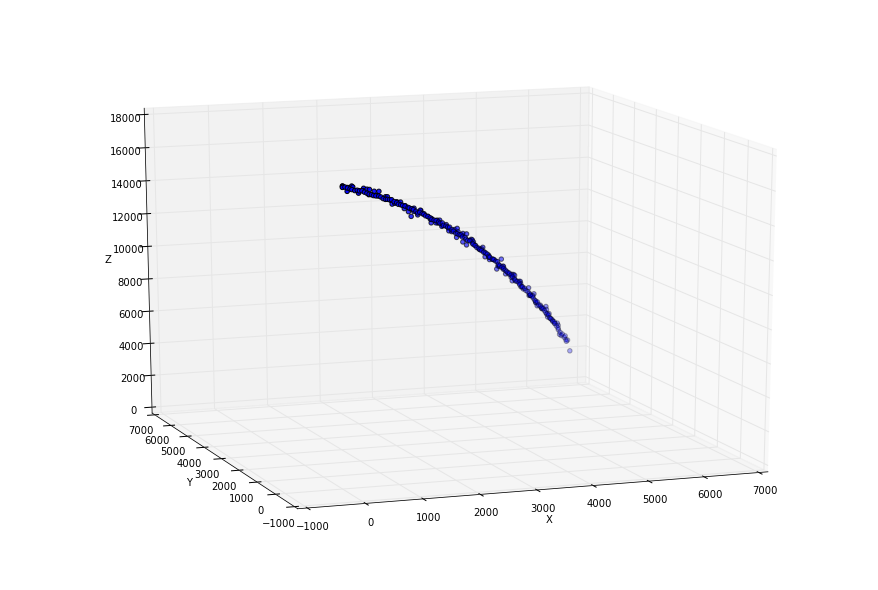

In [5]:
X_plot = path_data['X-Coord']
Y_plot = path_data['Y-Coord']
Z_plot = path_data['Z-Coord']
T_plot = path_data['Time']

fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-110, elev=15)
ax.scatter(X_plot, Y_plot, Z_plot)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

### The relationships between the variables can also be visualised separately:

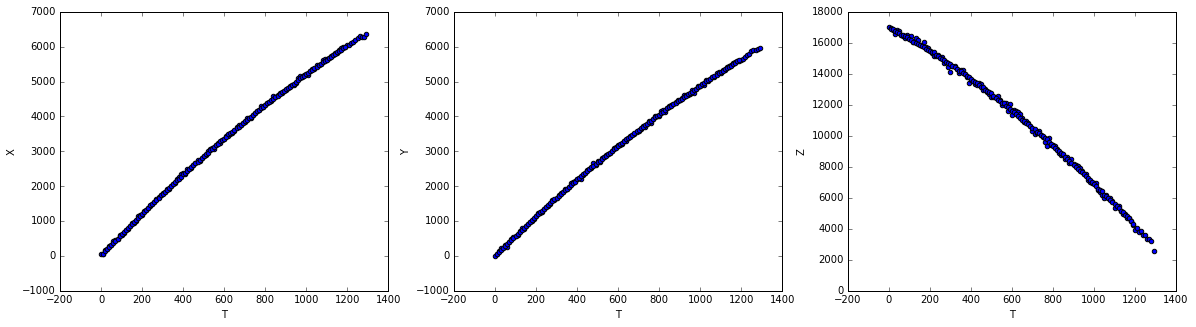

In [6]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 5))
ax1.scatter(T_plot, X_plot)
ax1.set_xlabel('T')
ax1.set_ylabel('X')
ax2.scatter(T_plot, Y_plot)
ax2.set_xlabel('T')
ax2.set_ylabel('Y')
ax3.scatter(T_plot, Z_plot)
ax3.set_xlabel('T')
ax3.set_ylabel('Z')

The first plot shows that both X and Y increase have a similar increasing relationship with T while Z has a decreasing relationship with T. The visualtions suggest that a polynomial regression model may be most suitable for the data and the laws of physics show that this should be a parabolic model (polynomial of degree 2). This can be confirmed using  k-fold cross validation on the training set to evaluate the fit of polynomials of different degrees. A k of 5 will be used. 

### Define Helper Functions for weighted polynomial regression:

In [7]:
# function that computes the weights and intercept of a linear regression fit using a weighted least squares approach
def weighted_linear_regression_fit(x_train, y_train, weights):
    A = np.diag(weights)
    n = x_train.shape[0]
    m = x_train.shape[1]
    ones_col = np.ones((n,1))
    
    # add a column of ones to mulitply the constant term 
    x = np.concatenate((x_train, ones_col), axis=1)
    xT = np.transpose(x)
    
    # intermediate term xTA
    xTA = np.dot(xT,A)
    xTAx = np.dot(xTA,x)
    xTAx_invXT = np.dot(np.linalg.pinv(xTAx), xT)
    
    # final matrix 
    xTAx_invXTA = np.dot(xTAx_invXT, A)
    
    # dot the final matrix with y_train
    w = np.dot(xTAx_invXTA, y_train)
    c = w[-1]
    return w[:-1], c

In [8]:
# function that computes the weights and intercept of a polynomial regression fit 
def polynomial_regression_fit(x_train, y_train, weights, degree):
    # Expand the array for x with columns for x^2, x^3, etc 
    # so that x_expanded is of size n x degree
    n = x_train.shape[0]
    x_expanded = np.zeros([n, degree])
    for d in range(1, degree + 1):
        x_expanded[:, d - 1] = np.power(x_train, d)
    w,c = weighted_linear_regression_fit(x_expanded, y_train, weights)
    return w, c

#--------  polynomial_regression_predict
# Input: 
#      w (d x 1 array of coefficients) 
#      c (float representing intercept)
#      degree (integer)
#      x_test (n x d array of predictors in testing data)
# Return: 
#      y_pred (n x 1 array of predicted y-vals) 
def polynomial_regression_predict(w, c, degree, x_test):

    # Expand the array for x with columns for x^2, x^3, etc 
    # so that x_expanded is of size n x degree
    n = x_test.shape[0]
    x_expanded = np.zeros([n, degree])
    for d in range(1, degree + 1):
        x_expanded[:, d - 1] = np.power(x_test, d)
        
    # Predict y-vals
    y_pred = np.dot(x_expanded, w) + c
        
    return y_pred


In [9]:
# function to calculate the R2 value
def polynomial_regression_score(y_pred, y_test):
    sq_error = np.sum(np.square(y_test - y_pred))
    y_mean = np.mean(y_test)
    y_variance = np.sum(np.square(y_test - y_mean))
    r_squared = 1 - sq_error / y_variance
    return r_squared

In [10]:
def calculateMSE(y_predict, y_test):
    return np.sum((y_test-y_predict)**2)/float(len(y_test))

In [11]:
def crossValidate(x, y, weights, max_degree):
    # shuffle data
    num_points = x.shape[0]
    indices = np.random.permutation(range(num_points))
    x_train = x[indices]
    y_train = y[indices]    
    
    # generate array of polynomial degrees values
    degrees = np.array(range(1,max_degree))
    num_degrees = len(degrees)
    
    # initialise empty arrays for saving r2 values
    test_CV_r_squared = np.zeros(num_degrees)
    test_CV_MSE = np.zeros(num_degrees)
    # generate folds 
    kf = KFold(num_points, n_folds=5)
    
    # iterate through the degrees
    for n, degree in enumerate(degrees):
        
        # initialise empty array to save r2 and mse values from the folds
        degree_test_r2 = np.zeros(5)
        degree_mse = np.zeros(5)
        
        i=0
        
        # iterate through the folds
        for train_index, test_index in kf:
            # split into test and train sets
            Xtrain, Xtest = x_train[train_index], x_train[test_index]
            Ytrain, Ytest = y_train[train_index], y_train[test_index]
            alpha = weights[train_index]
            # fit a ridge regression model for the particular value of degree
            w, c = polynomial_regression_fit(Xtrain, Ytrain, alpha, degree)
            YPredict = polynomial_regression_predict(w,c, degree, Xtest)
            
            # calculate the MSE of predicting on the test set from training on the training set
            degree_mse[i] = calculateMSE(YPredict, Ytest) 
            
            # calculate r2 for the testing set
            degree_test_r2[i] = polynomial_regression_score(YPredict, Ytest)
            i +=1
        
        # calculat the average MSE and R2 from all five folds
        test_CV_MSE[n] = np.mean(degree_mse)
        test_CV_r_squared[n] = np.mean(degree_test_r2)
        
        print 'Polynomial degree = ', degree, '   Test R2 = ', np.mean(degree_test_r2), '  TEST MSE= ', np.mean(degree_mse)
        
    # return an array of MSE and R2 (arrays with one element per lambda value)
    return test_CV_MSE, test_CV_r_squared, degrees

### Extract values of predictors and response:

In [12]:
X_plot = path_data['X-Coord'].values
Y_plot = path_data['Y-Coord'].values
Z_plot = path_data['Z-Coord'].values
T_plot = path_data['Time'].values
weights = path_data['alpha'].values

### Run Cross validation for T and Y:

Polynomial degree =  1    Test R2 =  0.99542641751   TEST MSE=  12598.6519537
Polynomial degree =  2    Test R2 =  0.999810882683   TEST MSE=  519.615139523
Polynomial degree =  3    Test R2 =  0.999823891945   TEST MSE=  482.73336872
Polynomial degree =  4    Test R2 =  0.980458323115   TEST MSE=  53966.2683269
Polynomial degree =  5    Test R2 =  0.463053992966   TEST MSE=  1471184.67415
Polynomial degree =  6    Test R2 =  0.169015225722   TEST MSE=  2269384.49574
Polynomial degree =  7    Test R2 =  -0.118498337802   TEST MSE=  3048078.4315


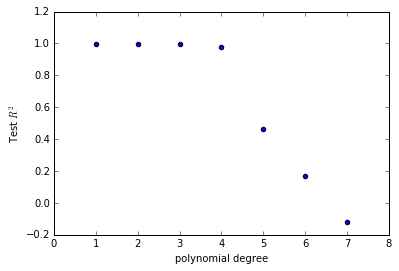

In [13]:
# Y predictions
test_CV_MSE, test_CV_r_squared, degrees = crossValidate(T_plot, Y_plot, weights, 8)
plt.scatter(degrees, test_CV_r_squared)
plt.xlabel('polynomial degree')
plt.ylabel('Test $R^2$')

### Run Cross validation for T and X:

Polynomial degree =  1    Test R2 =  0.995669532756   TEST MSE=  13582.6465921
Polynomial degree =  2    Test R2 =  0.999837866496   TEST MSE=  501.623735768
Polynomial degree =  3    Test R2 =  0.999841111655   TEST MSE=  490.08741406
Polynomial degree =  4    Test R2 =  0.981298604278   TEST MSE=  59692.6756315
Polynomial degree =  5    Test R2 =  0.483461398336   TEST MSE=  1626944.27614
Polynomial degree =  6    Test R2 =  0.19669967408   TEST MSE=  2525919.75402
Polynomial degree =  7    Test R2 =  -0.0968288008941   TEST MSE=  3443795.78705


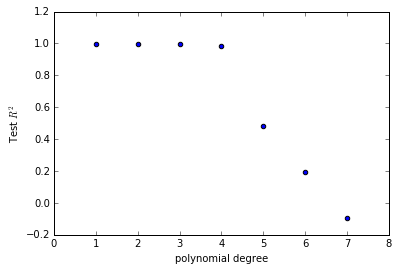

In [14]:
# X predictions
test_CV_MSE, test_CV_r_squared, degrees = crossValidate(T_plot, X_plot, weights, 8)
plt.scatter(degrees, test_CV_r_squared)
plt.xlabel('polynomial degree')
plt.ylabel('Test $R^2$')

### Run Cross validation for T and Z:

Polynomial degree =  1    Test R2 =  0.991927216127   TEST MSE=  123961.893403
Polynomial degree =  2    Test R2 =  0.999148019947   TEST MSE=  13173.1206426
Polynomial degree =  3    Test R2 =  -0.239568214341   TEST MSE=  18739155.8961
Polynomial degree =  4    Test R2 =  -1.94008788943   TEST MSE=  45005087.2163
Polynomial degree =  5    Test R2 =  -5.61841411589   TEST MSE=  101174267.527
Polynomial degree =  6    Test R2 =  -6.1995843572   TEST MSE=  109969180.949
Polynomial degree =  7    Test R2 =  -6.5949017182   TEST MSE=  115971131.045


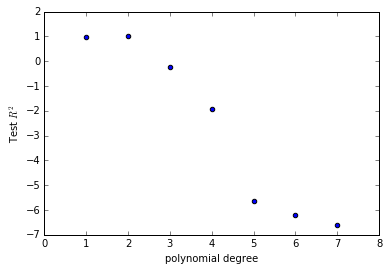

In [15]:
# Z predictions
test_CV_MSE, test_CV_r_squared, degrees = crossValidate(T_plot, Z_plot, weights, 8)
plt.scatter(degrees, test_CV_r_squared)
plt.xlabel('polynomial degree')
plt.ylabel('Test $R^2$')

The $R^2$ plots for X, Y and Z indicate that a 2nd degree polynomial will be the best fit to the data as expected. 

### Fit the chosen polynomial model for X , Y and Z as a function of T and visualise the resulting models:

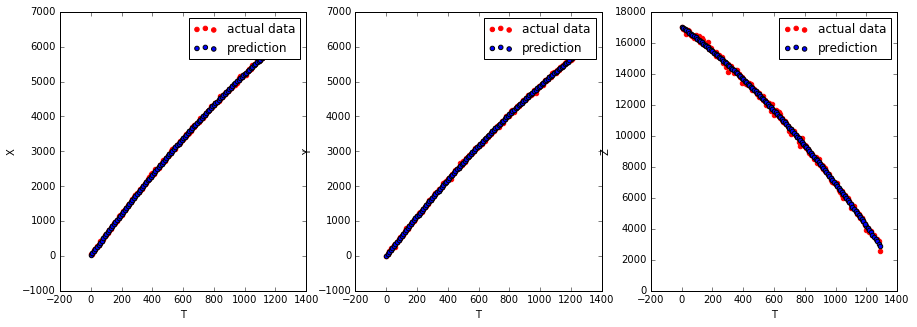

In [16]:
### predict X from Z
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 5))
w_x, c_x = polynomial_regression_fit(T_plot, X_plot, weights, 2)
X_predict = polynomial_regression_predict(w_x, c_x, 2, T_plot)

ax1.scatter(T_plot, X_plot, color='red', label='actual data')
ax1.scatter(T_plot, X_predict, label='prediction')
ax1.set_xlabel('T')
ax1.set_ylabel('X')
ax1.legend(loc='best')

w_y, c_y = polynomial_regression_fit(T_plot, Y_plot, weights, 2)
Y_predict = polynomial_regression_predict(w_y, c_y, 2, T_plot)

ax2.scatter(T_plot, Y_plot, color='red', label='actual data')
ax2.scatter(T_plot, Y_predict, label='prediction')
ax2.set_xlabel('T')
ax2.set_ylabel('Y')
ax2.legend(loc='best')

w_z, c_z = polynomial_regression_fit(T_plot, Z_plot, weights, 2)
Z_predict = polynomial_regression_predict(w_z, c_z, 2, T_plot)

ax3.scatter(T_plot, Z_plot, color='red', label='actual data')
ax3.scatter(T_plot, Z_predict, label='prediction')
ax3.set_xlabel('T')
ax3.set_ylabel('Z')
ax3.legend(loc='best')


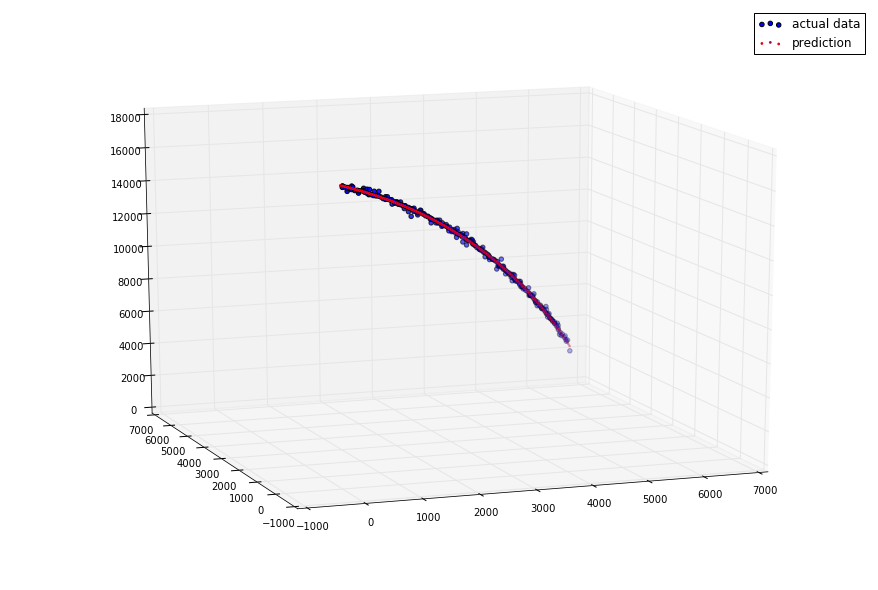

In [17]:
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-110, elev=15)
ax.scatter(X_plot, Y_plot, Z_plot, label='actual data')
ax.scatter(X_predict, Y_predict, Z_predict, color='red', s=3, label='prediction')
ax.legend(loc='best')

The plots show that 2nd degree polynomial models match the data closely and are a good fit. The models can be used to extrapolate the values of X, Y, and Z further into the future to determine the time and location of impact. The time of impact can be found by finding the roots of the polynomial model for Z - i.e. $Z = f(t)$ and set $Z = 0$ to solve for t. This value of time can then be input into the models for $X(t)$ and $Y(t)$ to determine the coordinates of impact. 

In [18]:
z_params = np.append(np.fliplr([w_z])[0], c_z)
poly = np.poly1d(z_params)
T_impact = poly.r[0]
print 'Roots of polynomial ', poly.r

Roots of polynomial  [-4097.62471316  1482.2132618 ]


The impact time is found to be at 1482 seconds as this is the only positive root.  

### Define helper functions to predict the time and location of impact: (to be used for bootstrapping)

In [19]:
# returns models for x, y and z
def model_xyz(X,Y,Z,T, weights):
    w_x, c_x = polynomial_regression_fit(T, X, weights, 2)
    w_y, c_y = polynomial_regression_fit(T, Y, weights, 2)
    w_z, c_z = polynomial_regression_fit(T, Z, weights, 2)
    return (w_x, c_x), (w_y, c_y), (w_z, c_z)

In [20]:
# returns predictions for x, y and z
def predict_xyz((w_x, c_x), (w_y, c_y), (w_z, c_z), T):
    Z_predict = c_z + w_z[0]*T + w_z[1]*(T**2)
    Y_predict = c_y + w_y[0]*T + w_y[1]*(T**2)
    X_predict = c_x + w_x[0]*T + w_x[1]*(T**2)
    return X_predict, Y_predict, Z_predict

In [21]:
# returns the predicted impact time and location 
def predict_impact((w_x, c_x), (w_y, c_y), (w_z, c_z)):
    b, a = w_z
    T_impact = (-b - np.sqrt(b**2 - 4*a*c_z))/float(2*a)
    Z_impact = c_z + w_z[0]*T_impact + w_z[1]*(T_impact**2)
    Y_impact = c_y + w_y[0]*T_impact + w_y[1]*(T_impact**2)
    X_impact = c_x + w_x[0]*T_impact + w_x[1]*(T_impact**2)
    return X_impact, Y_impact, T_impact

In [22]:
# x_poly, y_poly, z_poly = model_xyz(X_plot, Y_plot, Z_plot, T_plot, weights)
(w_x, c_x), (w_y, c_y), (w_z, c_z) = model_xyz(X_plot, Y_plot, Z_plot, T_plot, weights)
X_predict, Y_predict, Z_predict = predict_xyz((w_x, c_x), (w_y, c_y), (w_z, c_z), T_plot)
X_impact, Y_impact, T_impact = predict_impact((w_x, c_x), (w_y, c_y), (w_z, c_z))
print 'COORDINATES OF IMPACT'
print 'Time of Impact', T_impact, ' seconds'
print 'X Impact', X_impact, 'km'
print 'Y Impact', Y_impact, 'km'

COORDINATES OF IMPACT
Time of Impact 1482.2132618  seconds
X Impact 7030.37383004 km
Y Impact 6580.75822331 km


From the model the coordinates of impact are found to be approximately X = 7030 km , Y = 6580 km. The predictive intervals can be found by bootstrapping and re-running the predictions multiple times. 

### Calculate 90% Confidence Intervals for the prediction of X, Y using bootstrapping:

In [23]:
def bootstrap_predictions(path_data):
    num_iterations = 200
    # initialise empty arrays for the predicted impact locations
    x_predict = np.zeros(num_iterations)
    y_predict = np.zeros(num_iterations)
    t_predict = np.zeros(num_iterations)
    
    # size of the bootstrapped sample
    size = path_data.shape[0]

    for i in range(num_iterations):
        # Generate a random subsample of data points
        path_sample = path_data.sample(size, replace =True)
        
        # get the x,y, z, coordinates, time and weights
        x_subsample = path_sample['X-Coord'].values
        y_subsample = path_sample['Y-Coord'].values
        z_subsample = path_sample['Z-Coord'].values
        t_subsample = path_sample['Time'].values
        weights_subsample = path_sample['alpha'].values

        # fit a polynomial model for x, y and z
        x_poly, y_poly, z_poly = model_xyz(x_subsample, y_subsample, z_subsample, t_subsample, weights_subsample)
        # predict the impact location 
        X_impact, Y_impact, T_impact = predict_impact(x_poly, y_poly, z_poly)

        # save the locations
        x_predict[i]= X_impact
        y_predict[i] = Y_impact
        t_predict[i] = T_impact 
    return x_predict, y_predict

In [24]:
def plot_prediction_intervals(x_predict, y_predict):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # confidence intervals in the impact location 
    x_mean = np.mean(x_predict)
    y_mean = np.mean(y_predict)

    # Compute confidence interval at 90% confidence level
    x_conf_int_left = np.percentile(x_predict, 5)
    x_conf_int_right = np.percentile(x_predict, 95)

    y_conf_int_left = np.percentile(y_predict, 5)
    y_conf_int_right = np.percentile(y_predict, 95)

    print 'min ', str('X'), x_conf_int_left, ' max ', str('X'),  x_conf_int_right, ' mean ', x_mean, ' range ', x_conf_int_right- x_conf_int_left
    print 'min ', str('Y'), y_conf_int_left, ' max ', str('Y'),  y_conf_int_right, ' mean ', y_mean, ' range ', y_conf_int_right- y_conf_int_left

    # Plot histogram of response values
    axes[0].hist(x_predict, alpha=0.5)
    axes[1].hist(y_predict, alpha=0.5)

    # Plot vertical lines at mean and left, right extremes of confidence interval
    axes[0].axvline(x = x_mean, linewidth=3)
    axes[0].axvline(x = x_conf_int_left, linewidth=1, c='r')
    axes[0].axvline(x = x_conf_int_right, linewidth=1, c='r')

    # Set plot labels
    axes[0].set_title('[' + str(round(x_conf_int_left, 4)) 
                      + ', ' 
                      + str(round(x_conf_int_right, 4)) + ']')
    axes[0].set_xlabel(str('X'))
    axes[0].set_ylabel('Frequency')

    axes[1].axvline(x = y_mean, linewidth=3)
    axes[1].axvline(x = y_conf_int_left, linewidth=1, c='r')
    axes[1].axvline(x = y_conf_int_right, linewidth=1, c='r')

    axes[1].set_title('[' + str(round(y_conf_int_left, 4)) 
                      + ', ' 
                      + str(round(y_conf_int_right, 4)) + ']')
    axes[1].set_xlabel(str('Y'))
    axes[1].set_ylabel('Frequency')
    plt.show()
    return x_conf_int_left, x_conf_int_right, y_conf_int_left, y_conf_int_right

min  X 7021.68311445  max  X 7081.89521024  mean  7050.78249497  range  60.2120957838
min  Y 6555.15963885  max  Y 6631.10429907  mean  6591.70182069  range  75.9446602245


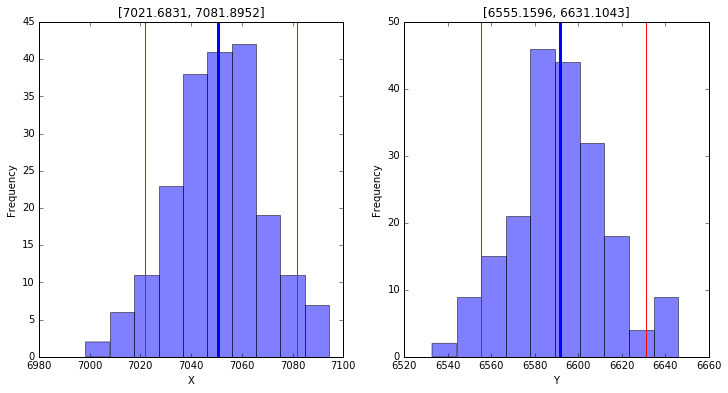

min  X 7008.59397249  max  X 7035.1634659  mean  7021.56044439  range  26.5694934044
min  Y 6561.94399371  max  Y 6591.29559073  mean  6575.33266377  range  29.351597016


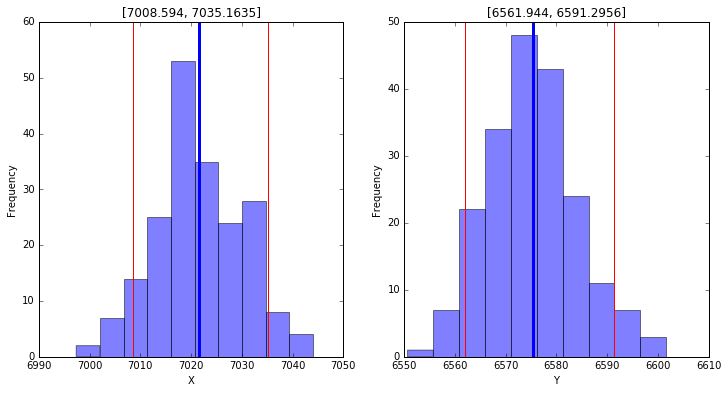

min  X 7018.77819017  max  X 7042.09776304  mean  7030.80827345  range  23.3195728726
min  Y 6567.10085062  max  Y 6593.67429559  mean  6580.98458628  range  26.5734449776


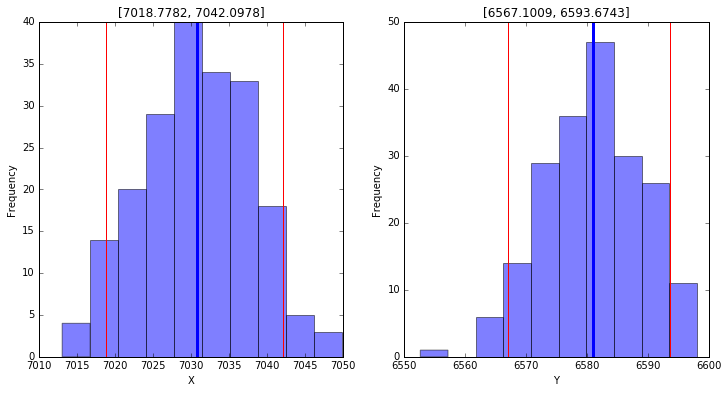

In [25]:
# only considering the noisy data with (each observation having weight 1)
path_noisy['aplha'] = path_noisy['alpha'] = pd.Series([1]*path_noisy.shape[0])
x_predict_noisy, y_predict_noisy = bootstrap_predictions(path_noisy)
x_min_noisy, x_max_noisy, y_min_noisy, y_max_noisy  = plot_prediction_intervals(x_predict_noisy, y_predict_noisy)

# considering only accurate data
x_predict_accurate, y_predict_accurate = bootstrap_predictions(path_accurate)
x_min_accurate, x_max_accurate, y_min_accurate, y_max_accurate = plot_prediction_intervals(x_predict_accurate, y_predict_accurate)

# considering both noisy and accurate data with weights 0.2 for noisy and 1 for accurate
x_predict, y_predict = bootstrap_predictions(path_data)
x_min, x_max, y_min, y_max = plot_prediction_intervals(x_predict, y_predict)

Predicting based only on the noisy data results in a much larger confidence interval in the prediction of the impact location with ranges in the X and Y positions of approximately 60km and 75km respectively. With the inclusion of the more accurate data and a weighting, the confidence intervals decrease considerably with a range of approximately 23km for X and  26km for Y. 

The confidence bounds can be used as an estimate of the impact region due to the meteorite. 

# Determine the impact on residents

## Load the data:

In [26]:
residents_df = pd.read_csv('pop_data.csv')
residents_df.head(10)

,residents,bed,bath,x,y
0,3.0,4,3,7201.60,6752.56
1,2.0,2,1,7079.68,6622.32
2,4.0,2,1,7154.40,6683.28
3,2.0,1,2,7093.44,6680.56
4,1.0,2,2,7198.72,6674.96
5,0.0,2,1,7101.76,6655.60
6,3.0,2,1,7157.28,6652.72
7,NaN,3,5,7088.00,6749.84
8,3.0,2,1,7160.00,6525.36
9,1.0,1,1,7201.60,6627.76


Observing the data, it can be seen that there are some observations with missing values. These number of residents for these observations can be imputed based on the remaining observations. 

In [27]:
no_y_ind = residents_df[residents_df['residents'].isnull()].index
with_y_ind = residents_df[residents_df['residents'].notnull()].index

print 'Number of missing data points ', len(no_y_ind)
print 'Total number of data points ', residents_df.shape[0]

affected_residents = residents_df[(residents_df.x >= x_min_noisy) & (residents_df.x <= x_max_noisy) & (residents_df.y >= y_min_noisy) & (residents_df.y <= y_max_noisy)]

no_y_ind_affected = affected_residents[affected_residents['residents'].isnull()].index

print 'Number of data points in the affected region', affected_residents.shape[0]
print 'Number of missing data points in the affected region', len(no_y_ind_affected)

Number of missing data points  761
Total number of data points  2417
Number of data points in the affected region 136
Number of missing data points in the affected region 24


### Fill in the missing values in the dataset:

Several methods could be used to fill in the missing values for the number of residents e.g. OLS, Ridge Regression, KNN. There are four possible predictors, bed, bath, x and y, which could be incorporated into a model. A possible solution is to use a ridge regression model using all four predictors. Ridge regression can help in adjusting the coefficient estimates so each coefficient is not very large and thus prevents overfitting. 

A ridge model will first be tested and if the $R^2$ fit of the model is not satisfactory a KNN model can be implemented. There are only 10 missing observations in the affected region so a rough estimate of the number of residents for these households will be sufficient. 

In [28]:
def ridge_select(df, with_y_ind):
    lambdas = range(-7, 7)
    
    # the data with y values is used as the data set for model selection
    predictors = df.loc[with_y_ind, ['bed', 'bath', 'x', 'y']].values
    response = df.loc[with_y_ind, ['residents']].values
    
    n = predictors.shape[0]
    indices = np.random.permutation(n)
    n_train = int(n * 0.7)
    
    # split into test and train sets
    
    #training set (70%)
    x_train = predictors[:n_train]
    x_train = x_train.reshape((n_train, 4)) #make this array 2D (row, column)
    y_train = response[:n_train]
    
    #training set 30%
    x_test = predictors[n_train:]
    x_test = x_test.reshape(((n-n_train), 4)) #make this array 2D (row, column)
    y_test = response[n_train:]
    
    r_squared = np.zeros(len(lambdas))
    for i,l in enumerate(lambdas):
        #fit linear model
        regression = Ridge_Reg(alpha=10**l)
        regression.fit(x_train, y_train)

        #score predictions
        r_squared[i] = regression.score(x_test, y_test)
    return r_squared, lambdas

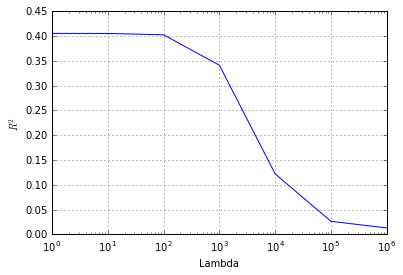

In [29]:
r_squared, lambdas = ridge_select(residents_df, with_y_ind)
plt.semilogx(10**np.array(lambdas), r_squared)
plt.grid(True)
plt.xlabel('Lambda')
plt.ylabel('$R^2$')

The $R^2$ values show that a ridge regression model with lambda in the range 0-100 provides the best fit to the data. Although the $R^2$ is only 0.4, it may be sufficient to determine the number of residents for the dwellings with missing data. 

In [30]:
# fit the model with the chosen value of lambda
def fill_lin_reg(df, with_y_ind, no_y_ind, lam):
    #spliting data into train/test and preparing data in array form
    predictors = df.loc[with_y_ind, ['bed', 'bath', 'x', 'y']].values
    response = df.loc[with_y_ind, ['residents']].values
    
    n = predictors.shape[0]
    indices = np.random.permutation(n)
    n_train = int(n * 0.7)
    #training set
    x_train = predictors[:n_train]
    x_train = x_train.reshape((n_train, 4)) #make this array 2D (row, column)
    y_train = response[:n_train]
    
    #training set
    x_test = predictors[n_train:]
    x_test = x_test.reshape(((n-n_train), 4)) #make this array 2D (row, column)
    y_test = response[n_train:]
    
    #fit linear model
    regression = Ridge_Reg(alpha=10**lam)
    regression.fit(x_train, y_train)
    #predict y-values
    predicted_y = list(map(int, regression.predict(x_test)[0]))
    
    #score predictions
    r = regression.score(x_test, y_test)
    
    #fill in missing y-values
    predicted_df = df.copy()
    predicted_df.loc[no_y_ind, 'residents'] = pd.Series(predicted_y, index=no_y_ind)
    
    return predicted_df, r

### Plot the locations of the all the dwellings in the town and the impact area:

In [31]:
# locations of all the dwellings 
print 'max X location ', residents_df['x'].max(), 'min X location ', residents_df['x'].min(), 'range  ', residents_df['x'].max() - residents_df['x'].min()
print 'max Y location ', residents_df['y'].max(), 'min Y location ', residents_df['y'].min(), 'range  ', residents_df['y'].max() - residents_df['y'].min()

max X location  7295.84 min X location  7024.16 range   271.68
max Y location  6785.84 min Y location  6514.16 range   271.68


R Squared of prediction model 0.405257045357


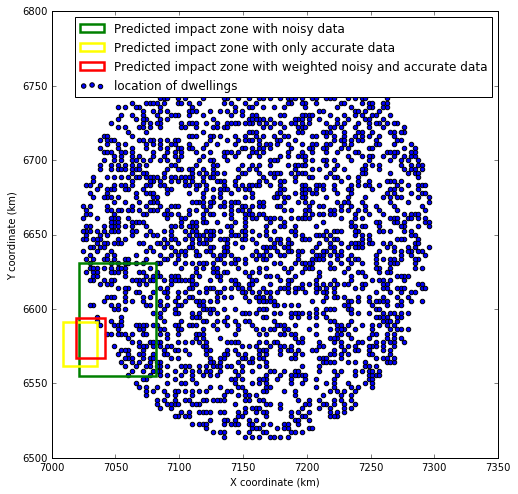

In [34]:
predicted_df, r = fill_lin_reg(residents_df, with_y_ind, no_y_ind, 1)
print 'R Squared of prediction model', r
predicted_df.head(10)
plt.figure(figsize=(8,8))
plt.scatter(predicted_df['x'], predicted_df['y'], label='location of dwellings')
plt.xlabel('X coordinate (km)')
plt.ylabel('Y coordinate (km)')
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((x_min_noisy, y_min_noisy), x_max_noisy-x_min_noisy, y_max_noisy-y_min_noisy, fill=None, alpha=1, color='green', linewidth=2.5, label='Predicted impact zone with noisy data'))
currentAxis.add_patch(Rectangle((x_min_accurate, y_min_accurate), x_max_accurate-x_min_accurate, y_max_accurate-y_min_accurate, fill=None, alpha=1, color='yellow', linewidth=2.5, label='Predicted impact zone with only accurate data'))
currentAxis.add_patch(Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, fill=None, alpha=1, color='red', linewidth=2.5, label='Predicted impact zone with weighted noisy and accurate data'))
plt.legend(loc='best')
plt.show()

The plot shows that the possible impact region is small compared to the size of the town (radius of town area is 271km compared to max width of the impact region which is at most 75km). The region is also on the edge of the town and there are few dwellings in the area so the impact on residents is not expected to be high (as a proportion of the total number of residents in the town). 

As expected, the predicted affected area is considerably smaller when the more accurate data is used to train the model as the estimate of the impact location is likely to be more accurate.  The size of the meteorite is also only 3m so if the predicted impact area is accurate, it is expected that the number of affected residents will also be small. 

In [33]:
# resident is in the affected zone if their house x,y coordinate lies in the impact region 

print 'Total number of residents', predicted_df['residents'].sum()

print '\nPREDICTIONS USING NOISY DATA\n'
affected_residents = predicted_df[(predicted_df.x >= x_min_noisy) & (predicted_df.x <= x_max_noisy) & (predicted_df.y >= y_min_noisy) & (predicted_df.y <= y_max_noisy)]
print 'Total number of affected households', affected_residents['residents'].shape[0]
print 'Total number of affected residents', affected_residents['residents'].sum()

print '\nPREDICTIONS USING ACCURATE DATA\n'
affected_residents = predicted_df[(predicted_df.x >= x_min) & (predicted_df.x <= x_max) & (predicted_df.y >= y_min) & (predicted_df.y <= y_max)]
print 'Total number of affected households', affected_residents['residents'].shape[0]
print 'Total number of affected residents', affected_residents['residents'].sum()


Total number of residents 4364.0

PREDICTIONS USING NOISY DATA

Total number of affected households 136
Total number of affected residents 320.0

PREDICTIONS USING ACCURATE DATA

Total number of affected households 2
Total number of affected residents 3.0


The analysis shows that when the noisy model is used, the impact area is larger hence a much larger number of households and residents are expected to be affected. 

When the more accurate data is used, the impact area is reduced and the number of affected residents is expected to be only 3. 